## google drive connection mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



## Env setup

In [ ]:
!git clone https://github.com/DepthAnything/Depth-Anything-V2
%cd Depth-Anything-V2
!pip install -r requirements.txt

Cloning into 'Depth-Anything-V2'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 136 (delta 41), reused 35 (delta 35), pack-reused 75 (from 1)
Receiving objects: 100% (136/136), 45.17 MiB | 10.95 MiB/s, done.
Resolving deltas: 100% (44/44), done.
/content/Depth-Anything-V2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64

In [ ]:
import cv2
import torch
from depth_anything_v2.dpt import DepthAnythingV2

DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

encoder = 'vitl' # or 'vits', 'vitb', 'vitg'

model = DepthAnythingV2(**model_configs[encoder])
model.load_state_dict(torch.load(f'checkpoints/depth_anything_v2_{encoder}.pth', map_location='cpu'))
model = model.to(DEVICE).eval()

# Set the path to your image in Google Drive
image_path = '/content/drive/My Drive/DepthAnything_assets/demo01.jpg'
raw_img = cv2.imread(image_path)
depth = model.infer_image(raw_img) # HxW raw depth map in numpy

# Display the depth map
import matplotlib.pyplot as plt
plt.imshow(depth, cmap='gray')
plt.show()

## 沒載model

KeyboardInterrupt: 

## Run huggingface model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

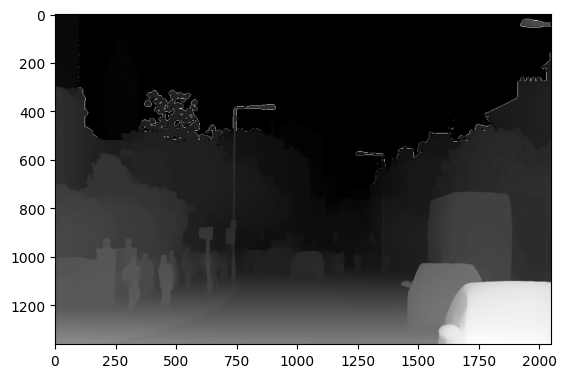

In [ ]:
from transformers import pipeline
from PIL import Image

pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf")
image_path = '/content/drive/My Drive/DepthAnything_assets/demo01.jpg'
image = Image.open(image_path)
depth = pipe(image)["depth"]

# Display the depth map
import matplotlib.pyplot as plt
plt.imshow(depth, cmap='gray')
plt.show()

## 3d plotting

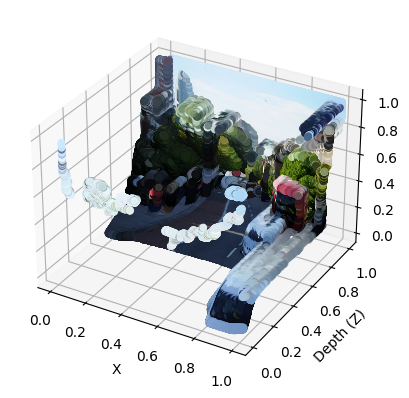

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the depth image
rgb_image_path = '/content/drive/My Drive/DepthAnything_assets/demo01.jpg'

rgb = Image.open(rgb_image_path)

# Convert images to numpy arrays
depth_array = np.array(depth)
rgb_array = np.array(rgb)

# Ensure depth and RGB image dimensions match
assert depth_array.shape == rgb_array.shape[:2], "Depth map and RGB image dimensions must match."

# Get the dimensions of the image
height, width = depth_array.shape

# Initialize arrays for x, y, z coordinates
x_coords = np.arange(width)
y_coords = np.arange(height)

# Create a meshgrid for x and y coordinates
x_grid, y_grid = np.meshgrid(x_coords, y_coords)

# Flatten the arrays to have a list of coordinates
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()
z_flat = depth_array.flatten()

x_flat = x_flat / width
y_flat = 1 - y_flat / height
z_flat = 1 - z_flat / np.max(z_flat)  # Normalizing z to [0, 1]

# Flatten the RGB arrays to get r, g, b values for each pixel
r_flat = rgb_array[:, :, 0].flatten() / 255.0
g_flat = rgb_array[:, :, 1].flatten() / 255.0
b_flat = rgb_array[:, :, 2].flatten() / 255.0

# Combine RGB values into a single color array
colors = np.vstack((r_flat, g_flat, b_flat)).T

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D points with RGB colors, swapping and inverting the Y and Z axes, and inverting the X axis
ax.scatter(x_flat, z_flat, y_flat, c=colors, marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Depth (Z)')
ax.set_zlabel('Y')

plt.show()


## generating CSV file

In [ ]:
# 0821
import numpy as np
import csv
from PIL import Image

def save_depth_rgb_to_csv(depth_array, rgb_array, output_filename):
    height, width = depth_array.shape

    # Create x and y coordinates
    x_coords = np.arange(width)
    y_coords = np.arange(height)

    # Create meshgrid for the x and y coordinates
    x_grid, y_grid = np.meshgrid(x_coords, y_coords)

    # Flatten the arrays
    x_flat = x_grid.flatten()
    y_flat = y_grid.flatten()
    z_flat = depth_array.flatten()

    # Normalize the x, y, z coordinates
    x_flat = x_flat / width
    y_flat = y_flat / height
    z_flat = z_flat / np.max(z_flat)  # Normalizing depth to [0, 1]

    # Flatten the RGB arrays to get r, g, b values for each pixel
    r_flat = rgb_array[:, :, 0].flatten() / 255.0
    g_flat = rgb_array[:, :, 1].flatten() / 255.0
    b_flat = rgb_array[:, :, 2].flatten() / 255.0

    # Open the file in write mode
    with open(output_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['x', 'y', 'z', 'r', 'g', 'b'])

        for i in range(len(x_flat)):
            writer.writerow([x_flat[i], y_flat[i], z_flat[i], r_flat[i], g_flat[i], b_flat[i]])

    print(f"Point cloud has been written to {output_filename}")

# Load the depth map and RGB image
depth_array = np.array(depth)
rgb_array = np.array(Image.open('/content/drive/My Drive/DepthAnything_assets/demo01.jpg'))

# Save to CSV
save_depth_rgb_to_csv(depth_array, rgb_array, '/content/drive/My Drive/DepthAnything_assets/point_cloud1.csv')


Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/point_cloud1.csv


In [ ]:
# Frame 0 - 5
def gen_csv(input_path, output_path):
  pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf")
  image_path = input_path
  image = Image.open(image_path)
  depth = pipe(image)["depth"]

  rgb_array = np.array(Image.open(input_path))
  save_depth_rgb_to_csv(np.array(depth), rgb_array, output_path)

for i in range(0, 6):
  input_path = "/content/drive/My Drive/DepthAnything_assets/frames/frame%d.jpg" % i
  gen_csv(input_path, "/content/drive/My Drive/DepthAnything_assets/frame%d.csv" % i)

Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame0.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame1.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame2.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame3.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame4.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame5.csv


In [ ]:
import numpy as np
# Frame 0 - 16
def gen_csv(input_path, output_path):
  pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf")
  image_path = input_path
  image = Image.open(image_path)
  depth = pipe(image)["depth"]

  rgb_array = np.array(Image.open(input_path))
  save_depth_rgb_to_csv(np.array(depth), rgb_array, output_path)

for i in range(0, 16):
  input_path = "/content/drive/My Drive/DepthAnything_assets/frames_v2/frame%d.jpg" % i
  gen_csv(input_path, "/content/drive/My Drive/DepthAnything_assets/frame%d.csv" % i)

Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame0.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame1.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame2.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame3.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame4.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame5.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame6.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame7.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame8.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame9.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame10.csv
Point cloud has been written to

In [ ]:
import numpy as np
# Frame 0 - 11
def gen_csv(input_path, output_path):
  pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf")
  image_path = input_path
  image = Image.open(image_path)
  depth = pipe(image)["depth"]

  rgb_array = np.array(Image.open(input_path))
  save_depth_rgb_to_csv(np.array(depth), rgb_array, output_path)

for i in range(0, 11):
  input_path = "/content/drive/My Drive/DepthAnything_assets/lib_frames/frame%d.jpg" % i
  gen_csv(input_path, "/content/drive/My Drive/DepthAnything_assets/frame%d.csv" % i)

Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame0.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame1.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame2.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame3.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame4.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame5.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame6.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame7.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame8.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame9.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame10.csv


In [ ]:
import numpy as np
# Frame 0 - 13
def gen_csv(input_path, output_path):
  pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf")
  image_path = input_path
  image = Image.open(image_path)
  depth = pipe(image)["depth"]

  rgb_array = np.array(Image.open(input_path))
  save_depth_rgb_to_csv(np.array(depth), rgb_array, output_path)

for i in range(0, 14):
  input_path = "/content/drive/My Drive/DepthAnything_assets/MVS_dataset/frame%d.JPG" % i
  gen_csv(input_path, "/content/drive/My Drive/DepthAnything_assets/frame%d.csv" % i)

Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame0.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame1.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame2.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame3.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame4.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame5.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame6.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame7.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame8.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame9.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame10.csv
Point cloud has been written to

In [ ]:
def save_depth_rgb_to_csv(depth_array, rgb_array, output_filename):
    height, width = depth_array.shape

    # Create x and y coordinates
    x_coords = np.arange(width)
    y_coords = np.arange(height)

    # Create meshgrid for the x and y coordinates
    x_grid, y_grid = np.meshgrid(x_coords, y_coords)

    # Flatten the arrays
    x_flat = x_grid.flatten()
    y_flat = y_grid.flatten()
    z_flat = depth_array.flatten()

    # Normalize the x, y, z coordinates
    x_flat = x_flat / width
    y_flat = y_flat / height
    z_flat = z_flat / np.max(z_flat)  # Normalizing depth to [0, 1]

    # Flatten the RGB arrays to get r, g, b values for each pixel
    r_flat = rgb_array[:, :, 0].flatten() / 255.0
    g_flat = rgb_array[:, :, 1].flatten() / 255.0
    b_flat = rgb_array[:, :, 2].flatten() / 255.0

    # Open the file in write mode
    with open(output_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['x', 'y', 'z', 'r', 'g', 'b'])

        for i in range(len(x_flat)):
            writer.writerow([x_flat[i], y_flat[i], z_flat[i], r_flat[i], g_flat[i], b_flat[i]])

    print(f"Point cloud has been written to {output_filename}")

## Kicker

In [ ]:
import numpy as np
import csv
from PIL import Image

def save_depth_rgb_to_csv(depth_array, rgb_array, output_filename):
    height, width = depth_array.shape

    # Create x and y coordinates
    x_coords = np.arange(width) # x對應到寬
    y_coords = np.arange(height) # y對應到高

    # Create meshgrid for the x and y coordinates
    x_grid, y_grid = np.meshgrid(x_coords, y_coords)

    # Flatten the arrays
    x_flat = x_grid.flatten()
    y_flat = y_grid.flatten()
    z_flat = depth_array.flatten()

    # Do not normalize the x, y, z coordinates here
    # x_flat and y_flat remain in pixel coordinates, z_flat remains in camera coordinates

    # Flatten the RGB arrays to get r, g, b values for each pixel
    r_flat = rgb_array[:, :, 0].flatten() / 255.0  # Normalizing RGB values to [0, 1]
    g_flat = rgb_array[:, :, 1].flatten() / 255.0
    b_flat = rgb_array[:, :, 2].flatten() / 255.0

    # Open the file in write mode
    with open(output_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['x', 'y', 'z', 'r', 'g', 'b'])

        for i in range(len(x_flat)):
            writer.writerow([x_flat[i], y_flat[i], z_flat[i], r_flat[i], g_flat[i], b_flat[i]])

    print(f"Point cloud has been written to {output_filename}")


In [ ]:
import numpy as np
# kicker, Frame 0-5
def gen_csv(input_path, output_path):
  pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf")
  image_path = input_path
  image = Image.open(image_path)
  depth = pipe(image)["depth"]

  rgb_array = np.array(Image.open(input_path))
  save_depth_rgb_to_csv(np.array(depth), rgb_array, output_path)

for i in range(6):
  input_path = "/content/drive/My Drive/DepthAnything_assets/kicker_frame/%d.JPG" % i
  gen_csv(input_path, "/content/drive/My Drive/DepthAnything_assets/frame%d.csv" % i)

Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame0.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame1.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame2.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame3.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame4.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame5.csv


In [ ]:
import numpy as np
# kicker, Frame 0-5
def gen_csv(input_path, output_path):
  pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf")
  image_path = input_path
  image = Image.open(image_path)
  depth = pipe(image)["depth"]

  rgb_array = np.array(Image.open(input_path))
  save_depth_rgb_to_csv(np.array(depth), rgb_array, output_path)

for i in range(6):
  input_path = "/content/drive/My Drive/DepthAnything_assets/pipe_image/%d.JPG" % i
  gen_csv(input_path, "/content/drive/My Drive/DepthAnything_assets/frame%d.csv" % i)

Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame0.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame1.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame2.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame3.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame4.csv
Point cloud has been written to /content/drive/My Drive/DepthAnything_assets/frame5.csv
